In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
import re
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token
import numpy as np
from nltk.stem.porter import PorterStemmer
import os

class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    """
    A transformer class for preprocessing text data using spaCy.

    This class is designed to be used in a sklearn pipeline. It uses the spaCy library to
    preprocess text data by performing a series of operations such as tokenization, lowercasing,
    stop word removal, punctuation removal, email and URL removal, stemming, lemmatization.
    """


    def __init__(self, model, *, batch_size = 64, lemmatize=True, lower=True, remove_stop=True,
                remove_punct=True, remove_email=True, remove_url=True, remove_num=False, stemming = False,
                add_user_mention_prefix=True, remove_hashtag_prefix=False):

        """
        Initialize the preprocessor.

        Parameters
        ----------
        model : spaCy model
            The spaCy model to use for preprocessing the text data.
        batch_size : int, optional (default=64)
            The batch size to use when processing the text data in batches.
        lemmatize : bool, optional (default=True)
            Whether to perform lemmatization on the text data.
        lower : bool, optional (default=True)
            Whether to lowercase the text data.
        remove_stop : bool, optional (default=True)
            Whether to remove stop words from the text data.
        remove_punct : bool, optional (default=True)
            Whether to remove punctuation from the text data.
        remove_email : bool, optional (default=True)
            Whether to remove email addresses from the text data.
        remove_url : bool, optional (default=True)
            Whether to remove URL addresses from the text data.
        remove_num : bool, optional (default=False)
            Whether to remove numbers from the text data.
        stemming : bool, optional (default=False)
            Whether to perform stemming on the text data.
        add_user_mention_prefix : bool, optional (default=True)
            Whether to change the behavior of the spaCy
            tokenizer to treat the @ symbol as a prefix.
        remove_hashtag_prefix : bool, optional (default=False)
            Whether to change the behavior of the spaCy
            tokenizer to no longer treat the # symbol as a prefix.
        """

        self.model = model
        self.batch_size = batch_size
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lower = lower
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix

        if lemmatize and stemming:
            raise ValueError("Only one of 'lammetize' and 'stemming' can be True.")

        self.lemmatize = lemmatize
        self.stemming = stemming


    def basic_clean(self, text):
        """Clean the input text by removing HTML tags and line breaks.

        Parameters
        ----------
        text : str
            The input text to clean.

        Returns
        -------
        str
            The cleaned text.
        """
        # Use BeautifulSoup to remove HTML tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()

        # Replace line breaks with spaces
        return re.sub(r'[\n\r]', ' ', text)

    def spacy_preprocessor(self, texts):
        """
        Preprocesses text data using spaCy's NLP library.
        Removes specified items such as stop words, punctuation, numbers, URLs, and emails.
        Also lemmatizes, stems, lowercase or keeps the text as is based on specified parameters.

        Parameters
        ----------
        texts : list or numpy array
            A list or numpy array of text data to preprocess

        Returns
        -------
        final_result : list
            A list of preprocessed text data
        """

        final_result = []
        nlp = spacy.load(self.model)

        # Disable unnecessary pipelines in spaCy model
        if self.lemmatize:
            # Disable parser and named entity recognition
            disabled = nlp.select_pipes(disable= [ 'parser', 'ner'])
        else:
            # Disable tagger, parser, attribute ruler, lemmatizer and named entity recognition
            disabled = nlp.select_pipes(disable= ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])

        # Add @ as a prefix so that we can separate the word from @
        prefixes = list(nlp.Defaults.prefixes)
        if self.add_user_mention_prefix:
            prefixes += ['@']

        # Remove # as a prefix so that we can keep hashtags and words together
        if self.remove_hashtag_prefix:
            prefixes.remove(r'#')

        # Compile prefix regex based on selected prefixes
        prefix_regex = spacy.util.compile_prefix_regex(prefixes)
        nlp.tokenizer.prefix_search = prefix_regex.search

        # Create a matcher to remove specified items from text data
        matcher = Matcher(nlp.vocab)
        if self.remove_stop:
            matcher.add("stop_words", [[{"is_stop" : True}]])
        if self.remove_punct:
            matcher.add("punctuation",[ [{"is_punct": True}]])
        if self.remove_num:
            matcher.add("numbers", [[{"like_num": True}]])
        if self.remove_url:
            matcher.add("urls", [[{"like_url": True}]])
        if self.remove_email:
            matcher.add("emails", [[{"like_email": True}]])

        # Determine number of cores to use in parallel processing
        num_cores = os.cpu_count()
        if num_cores < 3:
            use_cores = 1
        else:
            use_cores = num_cores // 2 + 1

        # Set custom attribute to track if a token should be removed
        Token.set_extension('is_remove', default=False, force=True, )

        cleaned_text = []

        # Process text data in parallel using spaCy's nlp.pipe()
        np.random.seed(0)
        for doc in nlp.pipe(texts, batch_size=self.batch_size,n_process=use_cores ):
            matches = matcher(doc)

            # Mark tokens for removal based on match results
            for _, start, end in matches:
                for token in doc[start:end]:
                    token._.is_remove = True

            ## Join the preprocessed text string based on the selected method (lemma, stem, text)
            if self.lemmatize:
                text = ' '.join(token.lemma_ for token in doc if (token._.is_remove==False))
            elif self.stemming:
                text = ' '.join(PorterStemmer().stem(token.text) for token in doc if (token._.is_remove==False))
            else:
                text = ' '.join(token.text for token in doc if (token._.is_remove==False))

            if self.lower:
                text=text.lower()
            cleaned_text.append(text)
        return cleaned_text

    def fit(self, X, y=None):
        """
        Dummy method for compatibility with sklearn's API.
        Fits the data and returns self.

        Parameters
        ----------
        X : numpy array or list
            A list or array of text data.
        y : None
            This argument is ignored and only present for compatibility with sklearn API.

        Returns
        -------
        self : object
            Returns self
        """
        return self

    def transform(self, X, y=None):
        """
        Transform the input data by preprocessing the text using spaCy's NLP library.

        Parameters
        ----------
        X : list or numpy array
            A list of text data to preprocess
        y : object, optional
            Ignored. Present for API compatibility by convention.

        Returns
        -------
        final_result : list
            A list of preprocessed text data

        """
        try:
            # Check if input is a list or numpy array
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f'Expected list or numpy array, got {type(X)}')

            # Clean the text data
            x_clean = [self.basic_clean(text).encode('utf-8', 'ignore').decode() for text in X]

            # Preprocess the text data using spaCy
            x_clean_final = self.spacy_preprocessor(x_clean)

            return x_clean_final
        except Exception as error:
            print(f'An exception occurred: {repr(error)}')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [3]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
import spacy
import re
import sys
import os
from pathlib import Path


class ManualFeatures(TransformerMixin, BaseEstimator):

    """A transformer class for extracting manual features from text data.

    This class is designed to be used in a scikit-learn pipeline. It uses the spaCy
    library to extract a variety of manual features from text data, such as
    part-of-speech (POS) features, named entity recognition (NER) features,
    and count-based features.
    """



    def __init__(self, spacy_model, pos_features = True, ner_features = True, count_features = True):

        """
        Initialize the feature extractor.

        Parameters
        ----------
        spacy_model : str
            The name of the spaCy model to use for feature extraction.
        pos_features : bool, optional (default=True)
            Whether to extract part-of-speech (POS) features from the text data.
        ner_features : bool, optional (default=True)
            Whether to extract named entity recognition (NER) features from the text data.
        count_features : bool, optional (default=True)
            Whether to extract count-based features from the text data.
        """

        self.spacy_model = spacy_model
        self.pos_features = pos_features
        self.ner_features = ner_features
        self.count_features = count_features

    def get_cores(self):
        """
        Get the number of CPU cores to use in parallel processing.
        """
        # Get the number of CPU cores available on the system.
        num_cores = os.cpu_count()
        if num_cores < 3:
            use_cores = 1
        else:
            use_cores = num_cores // 2 + 1
        return num_cores

    def get_pos_features(self, cleaned_text):
        """
        Extract part-of-speech (POS) features from the cleaned text.

        Parameters:
        cleaned_text (list): A list of cleaned text strings.

        Returns:
        numpy.ndarray: A 2D numpy array with shape (len(cleaned_text), 4) containing the count of nouns,
        auxiliaries, verbs, and adjectives for each text in the input list.
        """
        nlp = spacy.load(self.spacy_model)
        noun_count = []
        aux_count = []
        verb_count = []
        adj_count =[]

        # Disable the lemmatizer and NER pipelines for improved performance
        with nlp.disable_pipes(*['lemmatizer', 'ner']):
            n_process = self.get_cores()
            for doc in nlp.pipe(cleaned_text, batch_size=1000, n_process=n_process):\
                # Extract nouns, auxiliaries, verbs, and adjectives from the document
                nouns = [token.text for token in doc if token.pos_ in ["NOUN","PROPN"]]
                auxs =  [token.text for token in doc if token.pos_ in ["AUX"]]
                verbs =  [token.text for token in doc if token.pos_ in ["VERB"]]
                adjectives =  [token.text for token in doc if token.pos_ in ["ADJ"]]

                # Store the count of each type of word in separate lists
                noun_count.append(len(nouns))
                aux_count.append(len(auxs))
                verb_count.append(len(verbs))
                adj_count.append(len(adjectives))

        # Stack the count lists vertically to form a 2D numpy array
        return np.transpose(np.vstack((noun_count, aux_count, verb_count, adj_count)))



    def get_ner_features(self, cleaned_text):
        """
        Extract named entity recognition (NER) features from the cleaned text.

        Parameters:
        cleaned_text (list): A list of cleaned text strings.

        Returns:
        numpy.ndarray: A 2D numpy array with shape (len(cleaned_text), 1) containing
        the count of named entities for each text in the input list.
        """
        nlp = spacy.load(self.spacy_model)
        count_ner = []

        # Disable the tok2vec, tagger, parser, attribute ruler, and lemmatizer pipelines for improved performance
        with nlp.disable_pipes(*['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']):
            for doc in nlp.pipe(cleaned_text, batch_size=1000, n_process=-1):
                ners = [ent.label_ for ent in doc.ents]
                count_ner.append(len(ners))

        # Convert the list of NER counts to a 2D numpy array
        return np.array(count_ner).reshape(-1, 1)


    def get_count_features(self, cleaned_text):

        """
        Extract count-based features from the cleaned text.

        Parameters:
        cleaned_text (list): A list of cleaned text strings.

        Returns:
        numpy.ndarray: A 2D numpy array with shape (len(cleaned_text), 6) containing the count of words, characters, characters without spaces, average word length, count of digits, and count of numbers for each text in the input list.
        """

        list_count_words =[]
        list_count_characters =[]
        list_count_characters_no_space =[]
        list_avg_word_length=[]
        list_count_digits=[]
        list_count_numbers=[]
        for sent in cleaned_text:
          # Remove all digits followed by spaces from the text
            words = re.sub(r'\d+\s','',sent)

            # Extract all numbers from the text
            numbers = re.findall(r'\d+', sent)

            count_word = len(words.split())
            count_char = len(words)
            count_char_no_space = len(''.join(words.split()))
            avg_word_length = count_char_no_space/(count_word + 1)
            count_numbers = len(numbers)
            count_digits = len(''.join(numbers))

            list_count_words.append(count_word)
            list_count_characters.append(count_char)
            list_count_characters_no_space.append(count_char_no_space)
            list_avg_word_length.append(avg_word_length)
            list_count_digits.append(count_digits)
            list_count_numbers.append(count_numbers)

        # Stack the count lists vertically to form a 2D numpy array
        count_features = np.vstack((list_count_words, list_count_characters,
                                  list_count_characters_no_space, list_avg_word_length,
                                  list_count_digits,list_count_numbers ))
        return np.transpose(count_features)


    def fit(self, X, y=None):
        """
        Fit the feature extractor to the input data.

        This method does not actually do any fitting, as the feature extractor is stateless.
        It simply returns the instance of the class.

        Parameters:
        X (list or numpy.ndarray): The input data.
        y (list or numpy.ndarray, optional): The target labels. Not used in this implementation.

        Returns:
        FeatureExtractor: The instance of the class.
        """
        return self


    def transform(self, X, y=None):
        """
        Transform the input data into a set of features.

        Parameters:
        X (list or numpy.ndarray): The input data.
        y (list or numpy.ndarray, optional): The target labels. Not used in this implementation.

        Returns:
        tuple: A tuple containing a 2D numpy array with shape (len(X), num_features) where num_features is the number of features extracted and a list of feature names.

        Raises:
        TypeError: If the input data is not a list or numpy array.
        Exception: If an error occurs while transforming the data into features.
        """
        try:
            # Check if the input data is a list or numpy array
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f"Expected list or numpy array, got {type(X)}")

            # Initialize the preprocessor
            preprocessor1 = SpacyPreprocessor(model='en_core_web_sm', lemmatize=False, lower=False,
                                                remove_stop=False)
            preprocessor2 = SpacyPreprocessor(model='en_core_web_sm', lemmatize=False, lower=False,
                                                remove_stop=False, remove_punct=False)

            feature_names = []
            if self.pos_features or self.ner_features:
                cleaned_x_count_ner_pos = preprocessor2.fit_transform(X)

            if self.count_features:
                cleaned_x_count_features = preprocessor1.fit_transform(X)
                count_features = self.get_count_features(cleaned_x_count_features)
                feature_names.extend(['count_words', 'count_characters',
                                      'count_characters_no_space', 'avg_word_length',
                                      'count_digits', 'count_numbers'])
            else:
                count_features = np.empty(shape=(0, 0))

            if self.pos_features:
                pos_features = self.get_pos_features(cleaned_x_count_ner_pos)
                feature_names.extend(['noun_count', 'aux_count', 'verb_count', 'adj_count'])
            else:
                pos_features = np.empty(shape=(0, 0))

            if self.ner_features:
                ner_features = self.get_ner_features(cleaned_x_count_ner_pos)
                feature_names.extend(['ner'])
            else:
                ner_features = np.empty(shape=(0, 0))

            # Stack the feature arrays horizontally to form a single 2D numpy array
            return np.hstack((count_features, ner_features, pos_features)), feature_names

        except Exception as error:
            print(f'An exception occured: {repr(error)}')

<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


In [4]:
import pandas as pd
from pathlib import Path

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [5]:
df = pd.read_csv("/content/spam.csv",encoding='ISO-8859-1')
df = df[["v1","v2"]]
df.rename(columns={'v1': 'label','v2':'message'}, inplace=True)
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [19]:
df['label'].value_counts() * 100 / sum(df['label'].value_counts())

ham     86.593683
spam    13.406317
Name: label, dtype: float64

#cost benefit

# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

Ans) I will be using cost-sensitive learning or cost-sensitive optimization applied to logistic regression, specifically designed to address the challenges posed by unbalanced datasets. Directly using scoring metric as accuracy is sureley a bad ides, I'll be using cost sensitivity analysis in such a way that the cost gets reduced higher for imbalanced feature and lower for minority feature.

# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model.

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/).

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn:

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





In [6]:
category_to_label = {'spam': 0, 'ham': 1}  # Define your mapping as needed
df['label'] = df['label'].map(category_to_label)

In [7]:
train_smaller = df.sample(frac=0.1, replace=True, random_state=1)
y = train_smaller['label'].values
X = train_smaller['message'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (389,) y_train: (389,)
X_test: (168,) y_test: (168,)


In [8]:
# save this to a file
X_train_cleaned = SpacyPreprocessor(model='en_core_web_sm').transform(X_train)
file_cleaned_train_sparse_embed = "/content/x_train_cleaned_sparse_embed.pkl"
joblib.dump(X_train_cleaned, file_cleaned_train_sparse_embed)
X_test_cleaned = SpacyPreprocessor(model='en_core_web_sm').transform(X_test)
file_cleaned_test_sparse_embed = "/content/x_test_cleaned_sparse_embed.pkl"
joblib.dump(X_test_cleaned, file_cleaned_test_sparse_embed)

<ipython-input-1-547b75bd2624>:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['/content/x_test_cleaned_sparse_embed.pkl']

# ***Pipeline-1 (TF-IDF + Logistic regression)***

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

def custom_cost_scorer(estimator, X, y):
    cost_matrix = np.array([[0, 2.0], [0.6, 0.0]])  # Adjust as per your cost matrix
    y_pred = estimator.predict(X)  # Get predictions from the estimator
    conf_matrix = confusion_matrix(y, y_pred)
    total_cost = np.sum(conf_matrix * cost_matrix)
    return (-1.0)*total_cost


classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', LogisticRegression(max_iter=10000)),])
param_grid_classifier_1 = {'vectorizer__max_features': [1000, 2000, 5000],
                           'classifier__C': [1, 10, 100,]
                           }
grid_classifier_1 = GridSearchCV(
    estimator=classifier_1, param_grid=param_grid_classifier_1, cv=3,scoring=custom_cost_scorer)

X_train_cleaned_sparse_embed = joblib.load("/content/x_train_cleaned_sparse_embed.pkl")
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [1, 10, 100],
                         'vectorizer__max_features': [1000, 2000, 5000]},
             scoring=<function custom_cost_scorer at 0x7f375c1f20e0>)

In [10]:
print('Best cross-validation score: ',-1.0*(grid_classifier_1.best_score_))
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score:  11.333333333333334

Best parameters:  {'classifier__C': 100, 'vectorizer__max_features': 1000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])


In [11]:
file_best_estimator_pipeline1_round1 = '/content/pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = '/content/pipeline1_round1_complete_grid.pkl'
joblib.dump(grid_classifier_1.best_estimator_,
            file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)

['/content/pipeline1_round1_complete_grid.pkl']

In [12]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_complete_grid_pipeline1_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

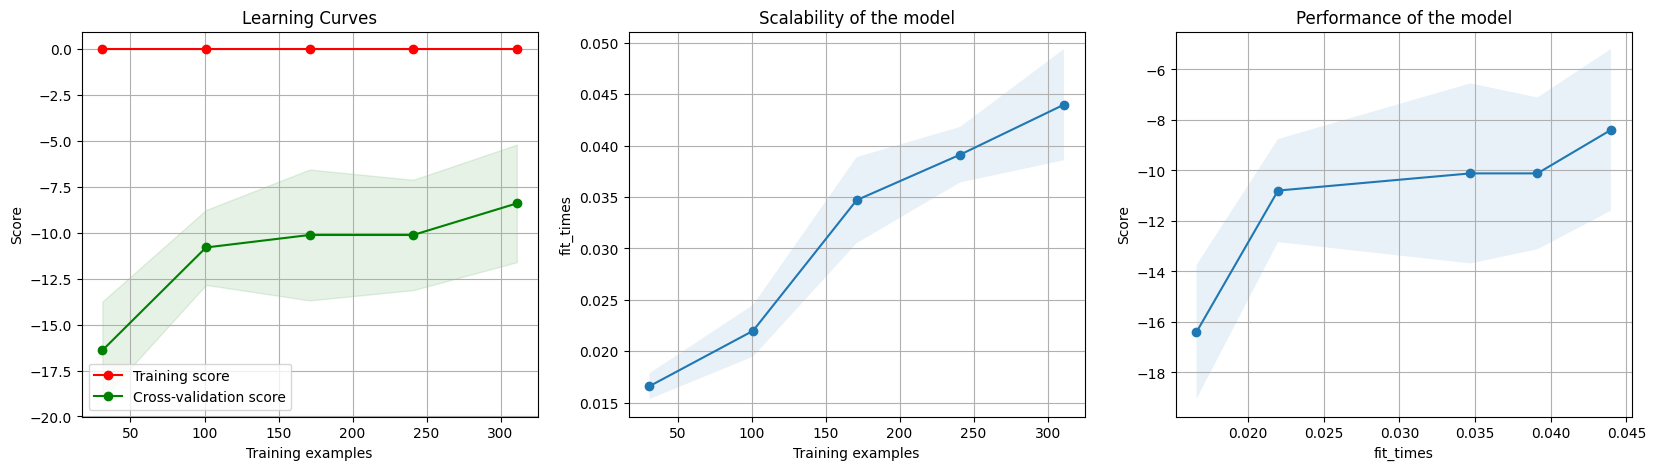

In [13]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train, n_jobs=-1,scoring = custom_cost_scorer)

**Clearly there is a overfit**

In [14]:
best_estimator_pipeline1_round1

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])

**Check Cross Validation Score and Train Score**

In [15]:
# let's check the train scores
print("Best training score :", -1.0*(custom_cost_scorer(best_estimator_pipeline1_round1,X_train_cleaned_sparse_embed, y_train)))

# let's check the cross validation score
print("Best cross_validation score ",-1.0*(round(complete_grid_pipeline1_round1.best_score_,2)))

Best training score : 0.0
Best cross_validation score  11.33


In [16]:
print("Testing data cost sensitivity analysis cost :",-1.0*(custom_cost_scorer(best_estimator_pipeline1_round1,X_test_cleaned,y_test)))

Testing data cost sensitivity analysis cost : 16.6


# ***Pipeline 2: Feature Engineering***

In [17]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')
X_train_features, feature_names = featurizer.fit_transform(X_train)
classifier_2 = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000)),
])
param_grid_classifier_2 = {'classifier__C': [0.01, 10, 1000, 100000]}
grid_classifier_2 = GridSearchCV(estimator=classifier_2,param_grid=param_grid_classifier_2,cv=3,scoring=custom_cost_scorer)
grid_classifier_2.fit(X_train_features, y_train)

<ipython-input-1-547b75bd2624>:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 10, 1000, 100000]},
             scoring=<function custom_cost_scorer at 0x7f375c1f20e0>)

In [18]:
print('Best cross-validation score: ',-1.0*(grid_classifier_2.best_score_))
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score:  2.8666666666666667

Best parameters:  {'classifier__C': 10}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=10, max_iter=10000))])


In [19]:
file_best_estimator_pipeline2_round1 = '/content/pipeline1_round2_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = '/content/pipeline1_round2_complete_grid.pkl'
joblib.dump(grid_classifier_2.best_estimator_,
            file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)

['/content/pipeline1_round2_complete_grid.pkl']

In [20]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(file_complete_grid_pipeline2_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

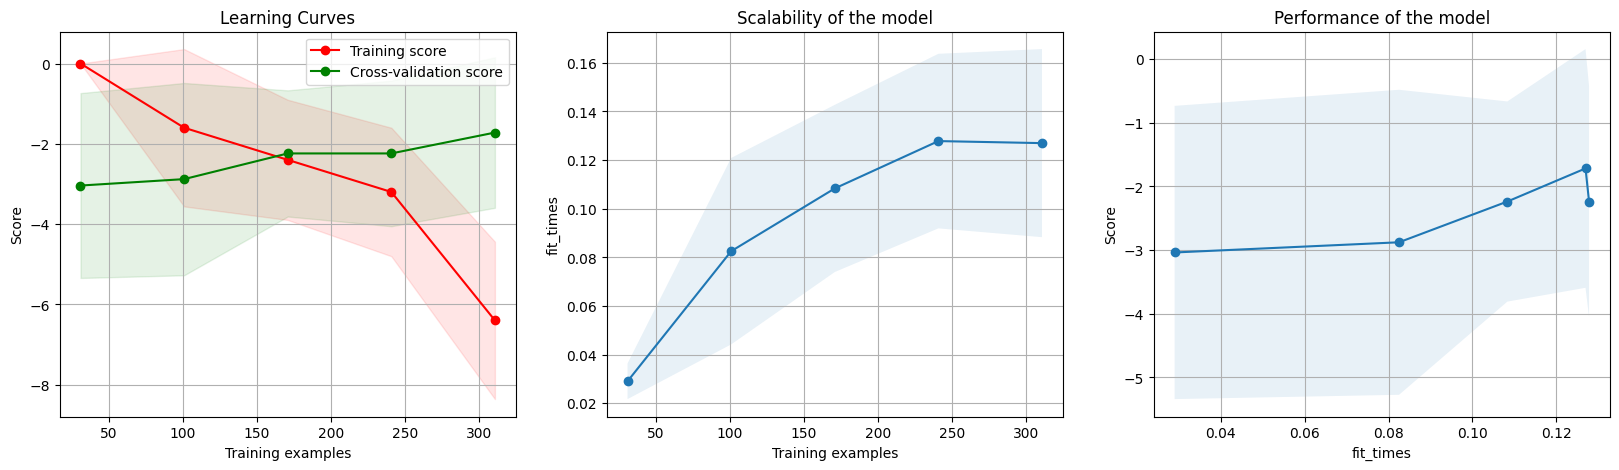

In [21]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1,scoring = custom_cost_scorer)

# ***Check Cross Validation Score and Train Score***

In [22]:
# let's check the train scores
print("Best training score :", -1.0*(custom_cost_scorer(best_estimator_pipeline2_round1,X_train_features, y_train)))

# let's check the cross validation score
print("Best cross_validation score ",-1.0*(round(complete_grid_pipeline2_round1.best_score_,2)))

Best training score : 8.0
Best cross_validation score  2.87


In [27]:
X_test_features, feature_names = featurizer.fit_transform(X_test)
print("Testing data cost sensitivity analysis cost for pipeline2 :",-1.0*(custom_cost_scorer(best_estimator_pipeline2_round1,X_test_features,y_test)))

<ipython-input-1-547b75bd2624>:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Testing data cost sensitivity analysis cost for pipeline2 : 10.6


# ***Pipeline 3: Combine Manual Features and TfID vectors***

In [28]:
X_train_cleaned_sparse_embed = joblib.load("/content/x_train_cleaned_sparse_embed.pkl")
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)
X_train_final

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,nope forget week,8.0,38.0,31.0,3.444444,0.0,0.0,1.0,1.0,1.0,2.0,1.0
1,plan stay night prolly will til late,18.0,75.0,58.0,3.052632,0.0,0.0,0.0,1.0,3.0,2.0,1.0
2,won guarantee å£1000 cash å£2000 prize claim y...,23.0,133.0,111.0,4.625000,24.0,6.0,3.0,11.0,0.0,4.0,1.0
3,po de need job aha,6.0,21.0,16.0,2.285714,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,ron fri leh n say ding tai feng not reservatio...,19.0,84.0,66.0,3.300000,0.0,0.0,2.0,9.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
384,know jack shit ask helpful want pretend text r...,35.0,195.0,161.0,4.472222,0.0,0.0,1.0,4.0,3.0,7.0,1.0
385,future plan tomorrow result today good present...,25.0,119.0,95.0,3.653846,0.0,0.0,1.0,6.0,3.0,3.0,1.0
386,\hey j r u feel well,7.0,29.0,23.0,2.875000,0.0,0.0,0.0,3.0,0.0,1.0,1.0
387,urgent 09061213237 landline å£5000 cash 4 holi...,19.0,96.0,78.0,3.900000,24.0,6.0,5.0,11.0,0.0,1.0,0.0


In [29]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                         ])

In [30]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# the typical value of cv used is 5. We are using 3, just for demonstration.
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                           'classifier__C': [0.1, 1, 10]
                           }
grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=3,scoring=custom_cost_scorer)
grid_classifier_3.fit(X_train_final, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]},
             scoring=<function custom_cost_scorer at 0x7f375c1f20e0>)

In [31]:
print("Best cross-validation score: {:.2f}".format(-1.0*(grid_classifier_3.best_score_)))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 2.67

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 500}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


In [32]:
file_best_estimator_pipeline3_round1 = '/content/pipeline1_round3_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = '/content/pipeline1_round3_complete_grid.pkl'
joblib.dump(grid_classifier_3.best_estimator_,
            file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

['/content/pipeline1_round3_complete_grid.pkl']

In [33]:
best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(file_complete_grid_pipeline3_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

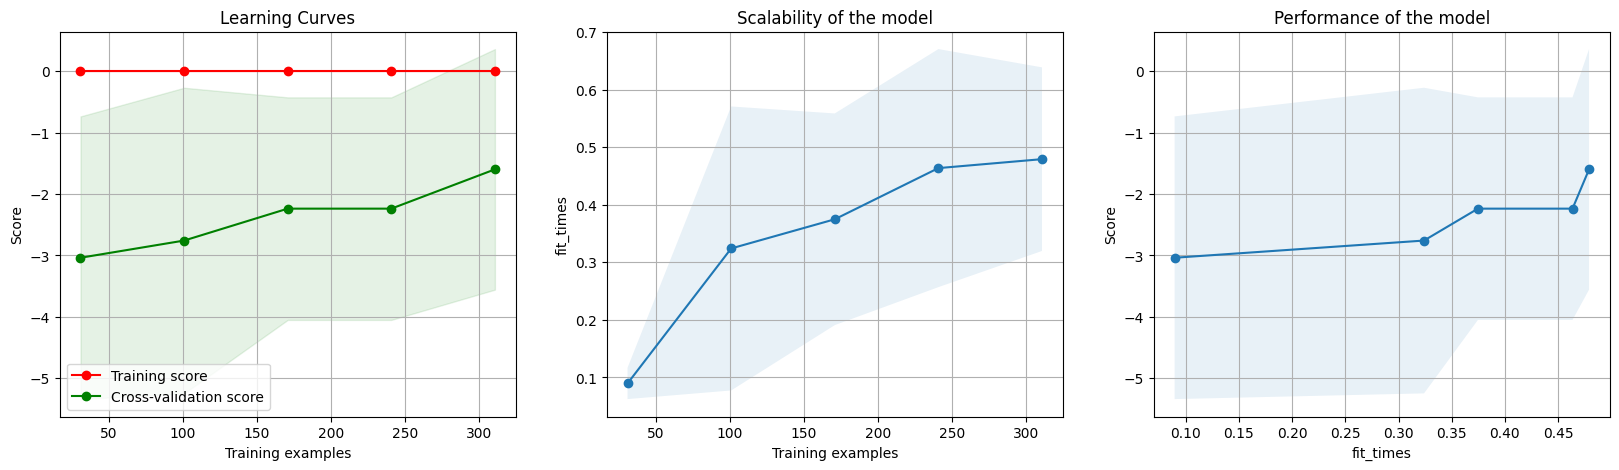

In [34]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1,scoring = custom_cost_scorer)

# **Check Cross Validation Score and Train Score**

In [35]:
# let's check the train scores
print("Best training score :", -1.0*(custom_cost_scorer(best_estimator_pipeline3_round1,X_train_final, y_train)))

# let's check the cross validation score
print("Best cross_validation score ",-1.0*(round(complete_grid_pipeline3_round1.best_score_,2)))

Best training score : 0.0
Best cross_validation score  2.67


In [38]:
X_test_features, feature_names = featurizer.fit_transform(X_test)
X_test_cleaned_sparse_embed = joblib.load("/content/x_test_cleaned_sparse_embed.pkl")
X_test_final = pd.concat((pd.DataFrame(X_test_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_test_features, columns=feature_names)), axis=1)
print("Testing data cost sensitivity analysis cost :",-1.0*(custom_cost_scorer(best_estimator_pipeline3_round1,X_test_final,y_test)))

<ipython-input-1-547b75bd2624>:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Testing data cost sensitivity analysis cost : 10.6


# **Clearly there is a Overfitting**

**Out of all the three pipeline's built, I would prefer Pipeine-2 for further analysis because pipeline-1 & 3 suffered from overfit, and pipeline-2 slightly suffered from underfit, which clearly indicates that increasing the fraction of dataset from 0.1 to 0.4 may give us a better parameter and training and testing scores.**

# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**